In [112]:
import numpy as np              # NumPy, for working with arrays/tensors 
import time                     # For measuring time
import random                   # Python's random library
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# PyTorch libraries:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt

from torch.utils.data import TensorDataset, DataLoader, Dataset
import torch.optim as optim

if torch.cuda.is_available():
  print("Cuda (GPU support) is available and enabled!")
  device = torch.device("cuda")
else:
  print("Cuda (GPU support) is not available :(")
  device = torch.device("cpu")


Cuda (GPU support) is not available :(


In [100]:
LABELS_FILEPATH = "./SMAP MSL/labeled_anomalies.csv"
TRAINSET_FILEPATH = "./SMAP MSL/data/data/train"
TESTSET_FILEPATH = "./SMAP MSL/data/data/test"

In [102]:
labels = pd.read_csv(LABELS_FILEPATH)
labels.info()
labels.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82 entries, 0 to 81
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   chan_id            82 non-null     object
 1   spacecraft         82 non-null     object
 2   anomaly_sequences  82 non-null     object
 3   class              82 non-null     object
 4   num_values         82 non-null     int64 
dtypes: int64(1), object(4)
memory usage: 3.3+ KB


,chan_id,spacecraft,anomaly_sequences,class,num_values
0,P-1,SMAP,"[[2149, 2349], [4536, 4844], [3539, 3779]]","[contextual, contextual, contextual]",8505
1,S-1,SMAP,"[[5300, 5747]]",[point],7331
2,E-1,SMAP,"[[5000, 5030], [5610, 6086]]","[contextual, contextual]",8516
3,E-2,SMAP,"[[5598, 6995]]",[point],8532
4,E-3,SMAP,"[[5094, 8306]]",[point],8307


In [103]:
# Data loading 
# T-10 data is not in Labels but in Train Dataset. Therefore, T-10 will not be used for now.
import os
train_datas = {}
test_datas = {}
arranged_train_datas = {}
arranged_test_datas = {}

desiredSC      = 'SMAP'
# Iterate directory
for path in os.listdir(TRAINSET_FILEPATH):
    # check if current path is a file
    if os.path.isfile(os.path.join(TRAINSET_FILEPATH, path)):
        if path != 'T-10.npy':
            SC_labels     = labels[labels['chan_id'] == path.replace('.npy','')]
            SC            = SC_labels['spacecraft']
            # print("SC_labels",SC_labels)
            # print("SC",SC)
            # print((SC.iloc[0]),path.replace('.npy',''))
            SC_name       = SC.iloc[0]
            if SC_name == desiredSC:
                train_data = np.load(os.path.join(TRAINSET_FILEPATH, path))
                train_datas[path] = train_data

for path in os.listdir(TESTSET_FILEPATH):
    # check if current path is a file
    if os.path.isfile(os.path.join(TESTSET_FILEPATH, path)):
        if path != 'T-10.npy':
            SC_labels     = labels[labels['chan_id'] == path.replace('.npy','')]
            SC            = SC_labels['spacecraft']
            SC_name       = SC.iloc[0]
            if SC_name == desiredSC:       
                test_data = np.load(os.path.join(TESTSET_FILEPATH, path))
                test_datas[path] = test_data

In [104]:
## Writing Functions

def windowed_Set(original_data, window_size, shifting,horizon):
    time_sequence_length, n_dimensions  = original_data.shape
    T = int((time_sequence_length - window_size-horizon) / shifting + 1)
    
    windowedArray = np.empty((n_dimensions, T, window_size))
    futuredArray  = np.empty((n_dimensions, T, horizon))

    for d in range(n_dimensions):
        for i in range(T):
            start_index = i * shifting
            window       = original_data[start_index : start_index + window_size,d]
            horizon_data = original_data[start_index + window_size : start_index + window_size + horizon,d]
            windowedArray[d, i, :] = window
            futuredArray[d, i, :]  = horizon_data
    return windowedArray, futuredArray

def normalize_data(data_, desired_mean, desired_std):
    """This code turns the input into have the desired mean and variance values. When standard deviation is zero, 
       since division will be infinity, it will bypass.
    """
    # Calculate the mean and variance of the original data
    data = data_.copy()
    original_mean = np.mean(data)
    original_std = np.std(data)
     
    # Subtract the mean from each data point
    data -= original_mean
    # Divide each data point by the square root of the variance
    if original_std != 0:
        data /= original_std
        # Multiply each data point by the desired standard deviation
        data *= desired_std
    # Add the desired mean to each data point
    data += desired_mean
    return data


In [105]:
## Normalization Parameters
INPUT_LENGTH = 100
wL = INPUT_LENGTH     # window length
zeta = 1             # horizon length (future length to predict)
shift = 20

#4.1 data normalization 
#1 - training normalization 
train_means = {}
train_variances = {}
windowedTrain = {}      # Dividing the data with windows
futuredTrain = {}       # Creating arrays to be futured

for train_data in train_datas:
    #print(train_datas[train_data].shape)
    D                                       = train_datas[train_data].shape[1]
    iN                                      = train_datas[train_data].shape[0]

    for D_ in range(D):
        train_datas[train_data][:,D_]       = normalize_data(train_datas[train_data][:,D_],0,1)
    #train_datas[train_data] = train_datas[train_data] * 2 - 1  # variance 1 olacak teyit et
    
    windowedTrain[train_data], futuredTrain[train_data] = windowed_Set(train_datas[train_data],wL,shift,zeta)

print("Total set number is:",len(windowedTrain),
      "\n1 Set name:",train_data,
      "\nSet shape:",train_datas[train_data].shape,"[t,D]",
      "\nWindowed array shape:",windowedTrain[train_data].shape,"[D,i,w]",
      "\nFutured array shape:",futuredTrain[train_data].shape,"[D,i,zeta]",
      "\nOne sample mean:", np.mean(train_datas[train_data]),
      "\nOne sample dimension variance:", np.std(train_datas[train_data][:,0]))
      


Total set number is: 54 
1 Set name: T-3.npy 
Set shape: (2876, 25) [t,D] 
Windowed array shape: (25, 139, 100) [D,i,w] 
Futured array shape: (25, 139, 1) [D,i,zeta] 
One sample mean: 1.3242382001648598e-16 
One sample dimension variance: 1.0


In [119]:
# Defining intermediate length and alpha before designing the modules
INTERMEDIATE_LENGTH         = 24
ALPHA                       = 0.1

In [106]:
windowedTest    = {}
futuredTest     = {}
test_means      = {}
test_variances  = {}
test_std        = {}

for test_data in test_datas:
    windowedTest[test_data], futuredTest[test_data] = windowed_Set(test_datas[test_data],wL,shift,zeta)

for test_data in test_datas:
    #print(test_datas[test_data].shape)
    D                               = windowedTest[test_data].shape[0]
    iN                              = windowedTest[test_data].shape[1]
    iN=2

    test_means[test_data]           = np.zeros((D,iN))
    test_variances[test_data]       = np.zeros((D,iN))
    test_std[test_data]             = np.zeros((D,iN))
    test_means[test_data][:,0]      = 0
    test_std[test_data][:,0]        = 0
    test_variances[test_data][:,0]  = 1 

    for iN_ in range(1,iN): 
        E                                = np.mean(windowedTest[test_data][:,iN_,:],axis = 1)
        E2                               = np.mean(windowedTest[test_data][:,iN_,:]**2,axis = 1)    
        test_means[test_data][:,iN_]     = (1-ALPHA)*test_means[test_data][:,iN_-1] + ALPHA*E 
        test_variances[test_data][:,iN_] = (1-ALPHA)*test_variances[test_data][:,iN_-1]+ALPHA*(E2-E**2)
        test_std[test_data][:,iN_]       = np.sqrt(test_variances[test_data][:,iN_-1])
        for D_ in range(D):
            dynamicMean                       = test_means[test_data][D_,iN_-1]
            dynamicVar                        = test_variances[test_data][D_,iN_-1]
            dynamicStd                        = test_std[test_data][D_,iN_-1]
            
            windowedTest[test_data][D_,iN_,:] = normalize_data(windowedTest[test_data][D_,iN_,:],dynamicMean,dynamicStd)

print("Window length:", wL,
      "\nShifting:",shift,
      "\nHorizon (zeta):",zeta,
      "\nTotal set number is:",len(windowedTest),
      "\n1 Set name:",test_data,
      "\nSet shape:",test_datas[test_data].shape,"[t,D]",
      "\nWindowed array shape:",windowedTest[test_data].shape,"[D,i,w]",
      "\nFutured array shape:",futuredTest[test_data].shape,"[D,i,zeta]",
      "\nTest means array shape:",test_means[test_data].shape,"[D,i]",
      "\nTest variance array shape:",test_variances[test_data].shape,"[D,i]")

Window length: 100 
Shifting: 20 
Horizon (zeta): 1 
Total set number is: 54 
1 Set name: T-3.npy 
Set shape: (8579, 25) [t,D] 
Windowed array shape: (25, 424, 100) [D,i,w] 
Futured array shape: (25, 424, 1) [D,i,zeta] 
Test means array shape: (25, 2) [D,i] 
Test variance array shape: (25, 2) [D,i]


In [107]:
print(train_datas.keys())
print('\n',test_datas.keys())
print('\n',labels['chan_id'].values)

dict_keys(['A-1.npy', 'A-2.npy', 'A-3.npy', 'A-4.npy', 'A-5.npy', 'A-6.npy', 'A-7.npy', 'A-8.npy', 'A-9.npy', 'B-1.npy', 'D-1.npy', 'D-11.npy', 'D-12.npy', 'D-13.npy', 'D-2.npy', 'D-3.npy', 'D-4.npy', 'D-5.npy', 'D-6.npy', 'D-7.npy', 'D-8.npy', 'D-9.npy', 'E-1.npy', 'E-10.npy', 'E-11.npy', 'E-12.npy', 'E-13.npy', 'E-2.npy', 'E-3.npy', 'E-4.npy', 'E-5.npy', 'E-6.npy', 'E-7.npy', 'E-8.npy', 'E-9.npy', 'F-1.npy', 'F-2.npy', 'F-3.npy', 'G-1.npy', 'G-2.npy', 'G-3.npy', 'G-4.npy', 'G-6.npy', 'G-7.npy', 'P-1.npy', 'P-2.npy', 'P-3.npy', 'P-4.npy', 'P-7.npy', 'R-1.npy', 'S-1.npy', 'T-1.npy', 'T-2.npy', 'T-3.npy'])

 dict_keys(['A-1.npy', 'A-2.npy', 'A-3.npy', 'A-4.npy', 'A-5.npy', 'A-6.npy', 'A-7.npy', 'A-8.npy', 'A-9.npy', 'B-1.npy', 'D-1.npy', 'D-11.npy', 'D-12.npy', 'D-13.npy', 'D-2.npy', 'D-3.npy', 'D-4.npy', 'D-5.npy', 'D-6.npy', 'D-7.npy', 'D-8.npy', 'D-9.npy', 'E-1.npy', 'E-10.npy', 'E-11.npy', 'E-12.npy', 'E-13.npy', 'E-2.npy', 'E-3.npy', 'E-4.npy', 'E-5.npy', 'E-6.npy', 'E-7.npy', 'E-8

In [110]:
# 4.2 temporal correlation
# in out sub block 
class InputSubBlock(nn.Module):

    def __init__(self):
        super(InputSubBlock, self).__init__()
        self.fc1 = nn.Linear(INPUT_LENGTH, 50)  # 5*5 from image dimension
        self.fc2 = nn.Linear(50, 50)
        self.fc3 = nn.Linear(50, 50)
        self.fc4 = nn.Linear(50, 50)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x
    
# cascade sub block 
class CascadeSubBlock(nn.Module):

    def __init__(self):
        super(CascadeSubBlock, self).__init__()
        self.fc1 = nn.Linear(50, 50)  # 5*5 from image dimension
        self.fc2 = nn.Linear(50, INPUT_LENGTH)
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return x
#forecasting sub block
class ForecastingSubBlock(nn.Module):

    def __init__(self):
        super(ForecastingSubBlock, self).__init__()
        self.fc1 = nn.Linear(50, 50)  # 5*5 from image dimension
        self.fc2 = nn.Linear(50, INTERMEDIATE_LENGTH)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return x
#MLPBlock
class MLPBlock(nn.Module):

    def __init__(self):
        super(MLPBlock, self).__init__()
        self.input = InputSubBlock()
        self.cascade = CascadeSubBlock()
        self.forecasting = ForecastingSubBlock()

    def forward(self, x):
        #print("1",x.shape)
        x = self.input(x)
        #print("2s",x.shape)
        cascade = self.cascade(x)
        
        forecast = self.forecasting(x)
        
        return cascade , forecast
class TemporalModule(nn.Module):
    def __init__(self):
        super(TemporalModule, self).__init__()
        self.mlp1 = MLPBlock() 
        self.mlp2 = MLPBlock() 

    def forward(self, input):
        mlp1_out , forecast = self.mlp1(input)
        new_input = mlp1_out - input 
        mlp2_out , forecast_2 = self.mlp2(new_input)
        return (forecast + forecast_2)

class SpatialModule(nn.Module):
    def __init__(self):
        super(SpatialModule, self).__init__()
        self.self_attention = nn.MultiheadAttention(embed_dim=INTERMEDIATE_LENGTH, num_heads=8, dropout=0.05)
        self.feed_forward = nn.Sequential(
            nn.Linear(INTERMEDIATE_LENGTH, 50),
            nn.ReLU(),
            nn.Dropout(0.05),
            nn.Linear(50,INTERMEDIATE_LENGTH)            
        )
    def forward(self, x):
        x, _ = self.self_attention(x, x, x)
        x = self.feed_forward(x)
        return x
    
class OutputModule(nn.Module):
    def __init__(self):
        super(OutputModule, self).__init__()
        self.FFN = nn.Linear(INTERMEDIATE_LENGTH,1)
    def forward(self, x):
        x = self.FFN(x)
        return x
    
class modeMARINA(nn.Module):
    def __init__(self):
        super(modeMARINA, self).__init__()
        self.temporal = TemporalModule()
        self.spatial  = SpatialModule()
        self.output   = OutputModule()
    def forward(self, x):
        x = self.temporal(x)
        x = self.spatial(x)
        x = self.output(x)
        return x  
    

In [113]:
class MarinaDataset(Dataset):
    def __init__(self, vec,label):
        self.vec = vec
        self.label = label
    def __len__(self):
        return len(self.vec)
    def __getitem__(self, idx):        
        return self.vec[idx], self.label[idx] 

In [114]:
# Stacking all data
alltrainDataT      = []    # Create a list for training data
allfuturedTrainT   = []    
for i,name in enumerate(windowedTrain.keys()):
    for j in range(windowedTrain[name].shape[1]):                                 # Looping over T dimension for stacking                              
        alltrainDataT.append(torch.tensor(windowedTrain[name][:,0,:]).float())   # Swapping the dimensions accordingly as (T,D,W).
        allfuturedTrainT.append(torch.tensor(futuredTrain[name][:,0,:]).float()) # Swapping the dimensions accordingly as (T,D,W).

    #print(windowedTrain[name].shape)
print("List length of whole trainDataT:",len(alltrainDataT),", and shape of input",alltrainDataT[1].shape,
      "\nLength of whole futured (targets) list:",len(allfuturedTrainT),", and shape of output",allfuturedTrainT[1].shape)

List length of whole trainDataT: 6650 , and shape of input torch.Size([25, 100]) 
Length of whole futured (targets) list: 6650 , and shape of output torch.Size([25, 1])


In [115]:
# Generate random indices for the validation set
valP            = 0.2 # Select 20% of the indices for validation
val_indices = random.sample(range(len(alltrainDataT)), k=int(len(alltrainDataT) * valP))  
# Split the data into training and validation sets
train_data, val_data, train_futured, val_futured = [], [], [], []
for i in range(len(alltrainDataT)):
    if i in val_indices:
        val_data.append(alltrainDataT[i])
        val_futured.append(allfuturedTrainT[i])
    else:
        train_data.append(alltrainDataT[i])
        train_futured.append(allfuturedTrainT[i])

print("Training data and futured:")
print(len(train_data),len(train_futured))
print("Validation data and futured:")
print(len(val_data),len(val_futured))


Training data and futured:
5320 5320
Validation data and futured:
1330 1330


In [116]:
# Training params
BATCH_SIZE                  = 128
lr                          = 0.005

trainset            = MarinaDataset(train_data,train_futured)
trainloader         = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,shuffle=True)      

validset            = MarinaDataset(val_data,val_futured)
validloader         = torch.utils.data.DataLoader(validset, batch_size=BATCH_SIZE,shuffle=True)
                                          

Epoch  1 	 Training Loss: 0.351314 	 Validation Loss: 0.157338
		 Validation Loss Decreased (inf --> 0.157338)
Epoch  2 	 Training Loss: 0.136627 	 Validation Loss: 0.112161
		 Validation Loss Decreased (0.157338 --> 0.112161)
Epoch  3 	 Training Loss: 0.117908 	 Validation Loss: 0.092915
		 Validation Loss Decreased (0.112161 --> 0.092915)
Epoch  4 	 Training Loss: 0.098904 	 Validation Loss: 0.118369
Epoch  5 	 Training Loss: 0.097280 	 Validation Loss: 0.096351
Epoch  6 	 Training Loss: 0.087033 	 Validation Loss: 0.089187
		 Validation Loss Decreased (0.092915 --> 0.089187)
Epoch  7 	 Training Loss: 0.084735 	 Validation Loss: 0.086588
		 Validation Loss Decreased (0.089187 --> 0.086588)
Epoch  8 	 Training Loss: 0.092235 	 Validation Loss: 0.088226
Epoch  9 	 Training Loss: 0.095636 	 Validation Loss: 0.090268
Epoch 10 	 Training Loss: 0.091281 	 Validation Loss: 0.091418
Epoch 11 	 Training Loss: 0.090319 	 Validation Loss: 0.086424
		 Validation Loss Decreased (0.086588 --> 0.08

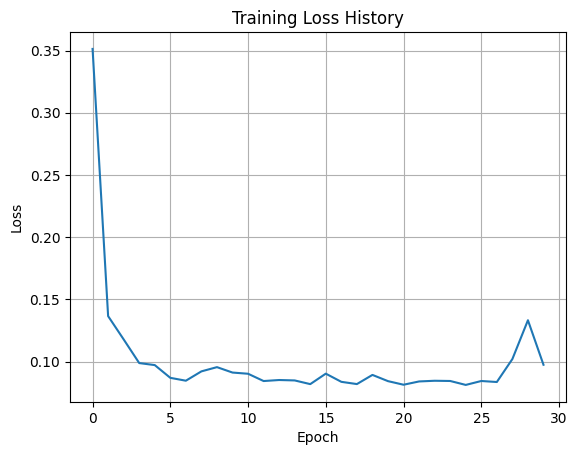

In [118]:
model           = modeMARINA()
model           = model.to(device)
criterion       = nn.MSELoss()
optimizer       = optim.Adam(model.parameters(), lr=lr)
min_valid_loss  = np.inf
epoch           = 30       # From the figure 7 in the paper.
loss_history    = []

start_time = time.time() # Setting starting point for finding the execution time

for epoch in range(epoch):  # loop over the dataset multiple times
    running_loss = 0.0
    model.train()
    
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        outputs = outputs.to(device)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
    valid_loss = 0.0
    model.eval()
    
    with torch.no_grad():
        for i, data in enumerate(validloader, 0):
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            outputs = outputs.to(device)
            loss = criterion(outputs, labels)
            valid_loss += loss.item()
    
    loss_history.append(running_loss / len(trainloader))
    print(f'Epoch {epoch+1:2d} \t Training Loss: {running_loss / len(trainloader):.6f} \t Validation Loss: {valid_loss / len(validloader):.6f}')

    if min_valid_loss > valid_loss:
        print(f'\t\t Validation Loss Decreased ({min_valid_loss/len(validloader):.6f} --> {valid_loss/len(validloader):.6f})')
        min_valid_loss = valid_loss
        # Saving State Dict
        # torch.save(model.state_dict(),'saved_model.pth')
    
print('Finished Training')

end_time = time.time()
execution_time = end_time - start_time
print(f"Total Execution Time: {execution_time:.2f} seconds")

# Plotting the loss history
plt.plot(loss_history)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss History')
plt.grid(True)
plt.show()
